In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [10]:
DATA_PATH = 'data/gestures.csv'
MODEL_PATH = 'models/model1.pth'

In [11]:
data = pd.read_csv(DATA_PATH, header = None)
print(f'Full data shape:{data.shape}')

Full data shape:(432, 14)


In [12]:
# Train and test sets
train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 0, stratify = data[0])

print(f'samples training data:{train_data.shape[0]} | samples test data:{test_data.shape[0]}')

samples training data:345 | samples test data:87


In [5]:
class LandmarkDataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        target = torch.tensor(self.df.values[:, 0]).type(torch.LongTensor)
        features = torch.tensor(self.df.values[:, 1:], dtype = torch.float)
        return features[index], target[index]
    
    
train_set = LandmarkDataset(train_data)
test_set = LandmarkDataset(test_data)

In [6]:
b_size = 16
trainloader = DataLoader(train_set, batch_size = b_size, shuffle = True)
testloader = DataLoader(test_set, batch_size = b_size, shuffle = False)

In [7]:
# checking data from DataLoader is as expected
x, y = next(iter(trainloader))
x.shape, y.shape

(torch.Size([16, 13]), torch.Size([16]))

Epoch 1/120
Train loss: 2.5636
Test accuracy: 13.79%
Epoch 2/120
Train loss: 2.5596
Test accuracy: 24.14%
Epoch 3/120
Train loss: 2.5545
Test accuracy: 28.74%
Epoch 4/120
Train loss: 2.5450
Test accuracy: 32.18%
Epoch 5/120
Train loss: 2.5266
Test accuracy: 31.03%
Epoch 6/120
Train loss: 2.4995
Test accuracy: 34.48%
Epoch 7/120
Train loss: 2.4761
Test accuracy: 36.78%
Epoch 8/120
Train loss: 2.4504
Test accuracy: 39.08%
Epoch 9/120
Train loss: 2.4185
Test accuracy: 43.68%
Epoch 10/120
Train loss: 2.3726
Test accuracy: 51.72%
Epoch 11/120
Train loss: 2.3212
Test accuracy: 55.17%
Epoch 12/120
Train loss: 2.2739
Test accuracy: 64.37%
Epoch 13/120
Train loss: 2.2187
Test accuracy: 64.37%
Epoch 14/120
Train loss: 2.1728
Test accuracy: 68.97%
Epoch 15/120
Train loss: 2.1373
Test accuracy: 70.11%
Epoch 16/120
Train loss: 2.1073
Test accuracy: 70.11%
Epoch 17/120
Train loss: 2.0809
Test accuracy: 71.26%
Epoch 18/120
Train loss: 2.0575
Test accuracy: 73.56%
Epoch 19/120
Train loss: 2.0318
Test 

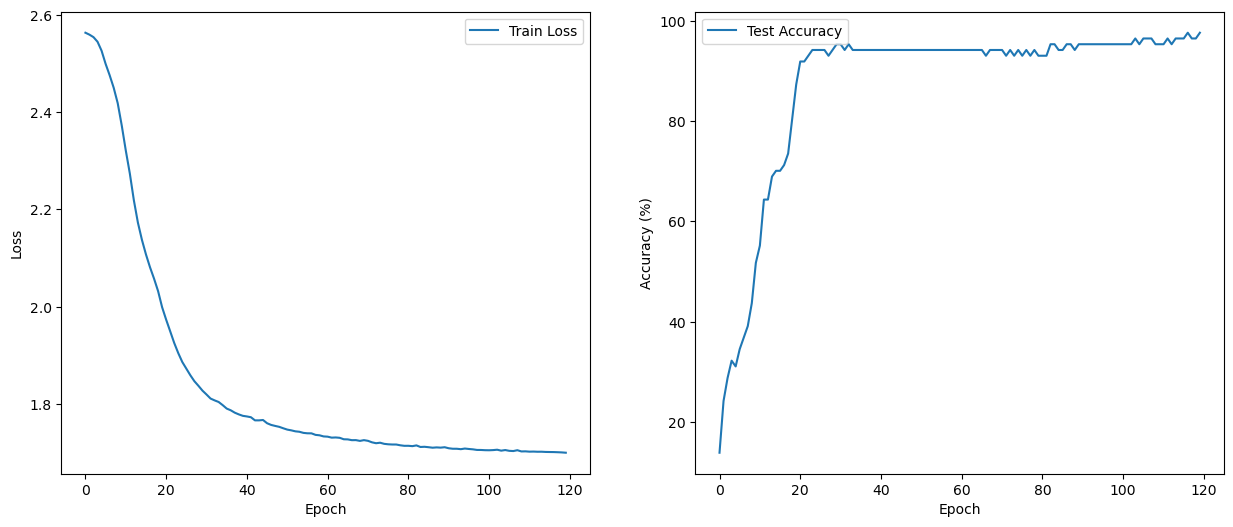

Final Test Accuracy: 97.70%
Final Train Loss: 1.6992


In [8]:
# ...existing imports and data loading code...

class FCNN(nn.Module):
    def __init__(self, n_features, n_classes, hidden_size):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(n_features, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.output = nn.Linear(hidden_size[1], n_classes)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.softmax(self.output(x), dim=1)

# Model initialization
n_features = data.shape[1] - 1
hidden_size = [32, 16]
n_classes = len(data[0].unique())
model = FCNN(n_features, n_classes, hidden_size)

# Training parameters
model.to(device)
learning_rate = 0.001
epochs = 120
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Lists for metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    running_loss = 0.0
    
    # Training phase
    model.train()
    for x_train, y_train in trainloader:
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)
    print(f'Train loss: {train_loss:.4f}')

    # Validation phase
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x_test, y_test in testloader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            
            outputs = model(x_test)
            loss = criterion(outputs, y_test)
            test_loss += loss.item()
            
            _, predicted = outputs.max(1)
            total += y_test.size(0)
            correct += predicted.eq(y_test).sum().item()
    
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f'Test accuracy: {accuracy:.2f}%')
    print('='*100)

# Save model
torch.save(model.state_dict(), MODEL_PATH)

# Plotting results
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss') 
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Display final metrics
print(f'Final Test Accuracy: {test_accuracies[-1]:.2f}%')
print(f'Final Train Loss: {train_losses[-1]:.4f}')